In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

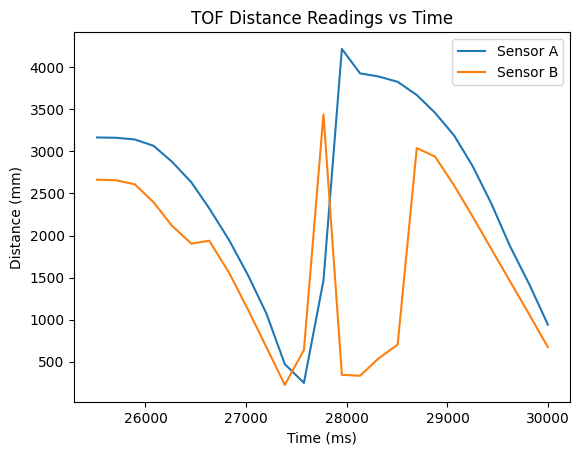

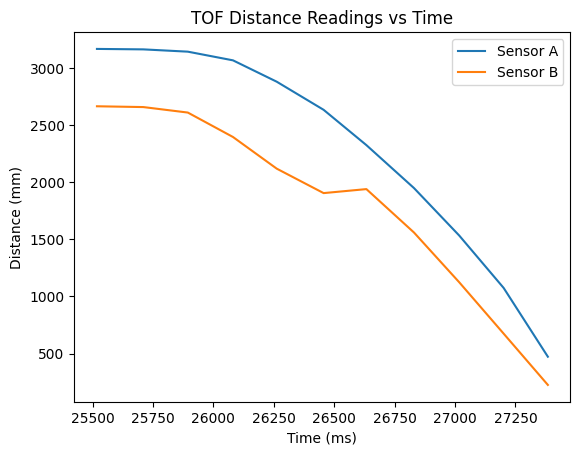

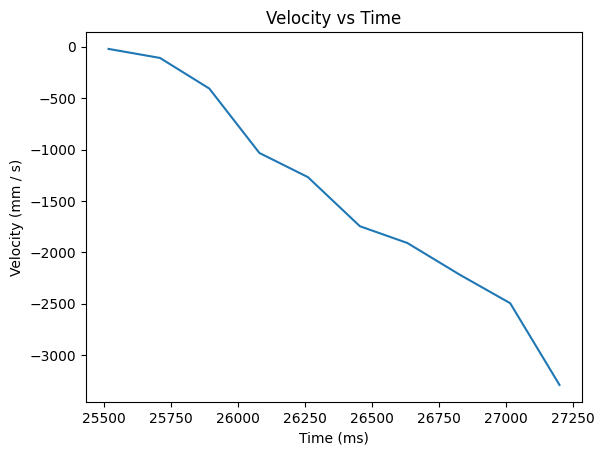

In [29]:
tof = np.load("tof_lab_7.npy")
tof = np.array(tof).astype(float)
plt.plot(tof[:, 0], tof[:, 1])
plt.plot(tof[:, 0], tof[:, 2])
plt.xlabel("Time (ms)")
plt.ylabel("Distance (mm)")
plt.title("TOF Distance Readings vs Time")
plt.legend(["Sensor A", "Sensor B"])
plt.show()
tof =  tof[tof[:, 0] < 27500]
plt.plot(tof[:, 0], tof[:, 1])
plt.plot(tof[:, 0], tof[:, 2])
plt.xlabel("Time (ms)")
plt.ylabel("Distance (mm)")
plt.title("TOF Distance Readings vs Time")
plt.legend(["Sensor A", "Sensor B"])
plt.show()

velocity = np.zeros((tof.shape[0]-1, 3)).astype(float)
velocity[:, 2] = [j-i for i, j in zip(tof[:-1, 0], tof[1:, 0])]
velocity[:, 0] = tof[:-1, 0]
velocity[:, 1] = [((j-i) * 1000.0) / k for i, j, k in zip(tof[:-1, 1], tof[1:, 1], velocity[:, 2])]
plt.plot(velocity[:, 0], velocity[:, 1])
plt.xlabel("Time (ms)")
plt.ylabel("Velocity (mm / s)")
plt.title("Velocity vs Time")
plt.show()

In [ ]:
u
d = u/xvel


Ad = np.eye(n) + Delta_T * A  #n is the dimension of your state space

